In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

stop = stopwords.words('english')

df1 = pd.read_csv("reviews_data_more.csv")
df2 = pd.read_csv("reviews_data_giant.csv")

df = pd.concat([df1, df2])
df 

,Unnamed: 0,Name,Street,Category,Price Tags,Average Rating,Review,Date,Rating
0,0,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,"The Sushi is definitely quality however, wait ...",2/18/2023,4
1,1,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,This place was delicious. Service was great. T...,8/31/2022,5
2,2,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,This place is legit. Fantastic Japanese food. ...,7/20/2022,5
3,3,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,Totemo oishii desu. @sushimaeda. Finally. The ...,6/6/2022,5
4,4,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,Food was slow to get to the table even though ...,9/27/2022,1
...,...,...,...,...,...,...,...,...,...
2688,2688,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,Voted best place to play pool in Burlington (2...,8/23/2016,5
2689,2689,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,update: Everytime I go here I leave pissed off...,9/10/2016,1
2690,2690,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,An amazing pizza menu with no option for dairy...,2/23/2015,1
2691,2691,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,Cool spot to grab a beer. Service is quick esp...,10/23/2017,5


In [2]:
#Add a year collumn to df
def add_year(df):
    df['year'] = pd.to_datetime(df['Date'], format='%m/%d/%Y').dt.year
    return df

# Get a dataframe with average review by year
def rating_year(df):
    grouped = df.groupby('year')['Rating'].agg(['mean', 'count'])
    grouped.columns = ['Average Rating', 'Number of Reviews']
    return grouped.reset_index()

In [3]:
df = add_year(df)

year_df = rating_year(df)
year_df

,year,Average Rating,Number of Reviews
0,2008,4.000000,1
1,2009,1.000000,1
2,2011,4.250000,8
3,2012,3.333333,6
4,2013,3.769231,13
5,2014,3.814815,27
6,2015,4.065789,76
7,2016,3.861386,101
8,2017,3.931373,102
9,2018,3.701987,151


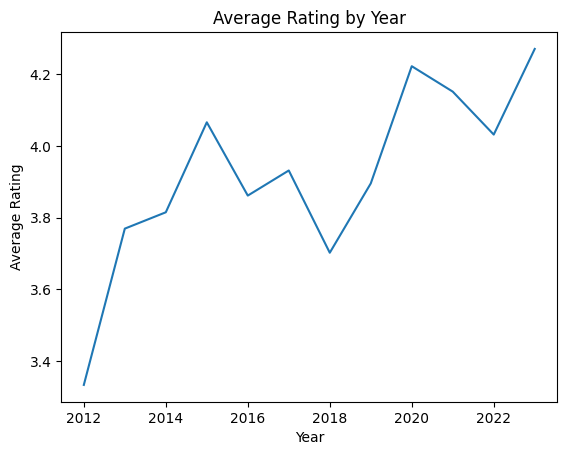

In [4]:
#Plot rating by year
plt.plot(year_df['year'][3:], year_df[3:]['Average Rating'])
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating by Year')
plt.show()

In [5]:
import re
def clean_punctuation(column):
    chars = r'[!()-\[\]{};:\'"\\,<>./?@#$%^&*_~]'
    cleaned_column = column.apply(lambda x: re.sub(chars, '', x))
    
    # Return the cleaned column
    return cleaned_column

In [6]:
def process_data(data):
 
    # Transform Data, Select Features
    data = select_columns(data,'Street','Price Tags', 'Review text', 'Category 1', 'Category 2', 'Customer Satisfaction')
    
    #turn y ('Customer Satisfaction') into either 1 or 0
    df['Customer Satisfaction'] = df['Customer Satisfaction'].map({'High': 1, 'Low': 0})
    
    return data

In [7]:
def fix_missing(df):
    '''Function to fill in missing data with the mode'''
    
    #find the modes
    modes = df.mode()
    mode_list = modes.values.tolist()[0]
    
    
    df[['Street']] = df[['Street']]. fillna(str(mode_list[0]))
    df[['Price Tags']] = df[['Price Tags']]. fillna(str(mode_list[1]))
    df[['Category 1']] = df[['Category 1']]. fillna(str(mode_list[3]))
    df[['Category 2']] = df[['Category 2']]. fillna(str(mode_list[4]))
    
    return df

In [8]:
def clean(full_df):
    stop = stopwords.words('english')
    # Clean Reviews 
    full_df['Review'] = full_df['Review'].str.replace(';', '\'')
    full_df['Review'] = full_df['Review'].str.replace('<br&gt;', '')
    full_df['Review'] = full_df['Review'].str.replace('&', '')
    full_df['Review'] = full_df['Review'].str.replace('amp;', '')
    full_df['Review'] = full_df['Review'].str.replace('amp', '')
    full_df['Review'] = full_df['Review'].str.replace('  ', ' ')
    full_df['Review'] = full_df['Review'].str.replace('#39\'', ' ')

    # Make all lowercase
    full_df['Review'] = full_df['Review'].apply(str.lower)

    # Add custom stop words
    custom_stop_words = ['food', 'burlington', 'would', '-']
    stop = stop + custom_stop_words
    full_df['Review'] = full_df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    
    #Remove punctuation
    full_df['Review'] = clean_punctuation(full_df['Review'])
    
    return full_df

In [9]:
#Clean reviews
df = clean(df)

#Add satisfaction
df['Customer Satisfaction'] = df['Rating'].replace([1, 2, 2.5, 3.0, 3.5], 'Low')
df['Customer Satisfaction'] = df['Customer Satisfaction'].replace( [4.0, 4.5, 5], 'High')
df

,Unnamed: 0,Name,Street,Category,Price Tags,Average Rating,Review,Date,Rating,year,Customer Satisfaction
0,0,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,sushi definitely quality however wait times lo...,2/18/2023,4,2023,High
1,1,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,place delicious service great menu pure lot fr...,8/31/2022,5,2022,High
2,2,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,place legit fantastic japanese food sure servi...,7/20/2022,5,2022,High
3,3,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,totemo oishii desu sushimaeda finally japanese...,6/6/2022,5,2022,High
4,4,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,slow get table even though place wasn busy brg...,9/27/2022,1,2022,Low
...,...,...,...,...,...,...,...,...,...,...,...
2688,2688,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,voted best place play pool agree i times week...,8/23/2016,5,2016,High
2689,2689,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,update everytime go leave pissed off not worth...,9/10/2016,1,2016,Low
2690,2690,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,amazing pizza menu option dairyfree please sup...,2/23/2015,1,2015,Low
2691,2691,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,cool spot grab beer service quick especially d...,10/23/2017,5,2017,High


In [10]:
def process_data(data):
 
    X = data['Review']
    y = data['Customer Satisfaction']


    return X, y

In [11]:
data = df.copy()
train, val = train_test_split(data, train_size=.8, random_state=42)
#train = make_rows_equal(train)
X_train, y_train = process_data(train)
data

,Unnamed: 0,Name,Street,Category,Price Tags,Average Rating,Review,Date,Rating,year,Customer Satisfaction
0,0,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,sushi definitely quality however wait times lo...,2/18/2023,4,2023,High
1,1,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,place delicious service great menu pure lot fr...,8/31/2022,5,2022,High
2,2,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,place legit fantastic japanese food sure servi...,7/20/2022,5,2022,High
3,3,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,totemo oishii desu sushimaeda finally japanese...,6/6/2022,5,2022,High
4,4,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,slow get table even though place wasn busy brg...,9/27/2022,1,2022,Low
...,...,...,...,...,...,...,...,...,...,...,...
2688,2688,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,voted best place play pool agree i times week...,8/23/2016,5,2016,High
2689,2689,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,update everytime go leave pissed off not worth...,9/10/2016,1,2016,Low
2690,2690,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,amazing pizza menu option dairyfree please sup...,2/23/2015,1,2015,Low
2691,2691,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,cool spot grab beer service quick especially d...,10/23/2017,5,2017,High


In [12]:
#Compute weights to use for regresssion
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))


In [13]:
vectorizer = CountVectorizer(stop_words=stop,max_features=100) # SOLUTION NO PROMPT
X_train = vectorizer.fit_transform(train["Review"]) # SOLUTION
Y_train = train["Customer Satisfaction"] # SOLUTION
train_vocab = vectorizer.get_feature_names_out() # SOLUTION

In [14]:
model = LogisticRegression(random_state=1000, class_weight=class_weight_dict) # SOLUTION
model.fit(X_train,Y_train) # SOLUTION NO PROMPT
training_accuracy = model.score(X_train,Y_train) # SOLUTION
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.800957319505385


In [15]:
def make_rows_equal(df):
    # Count the number of 'High' and 'Low' values in the 'Customer Satisfaction' column
    counts = df['Customer Satisfaction'].value_counts()
    num_high = counts['High']
    num_low = counts['Low']
    
    # Duplicate rows with 'Low' value until number of rows with 'Low' equals number of rows with 'High'
    if num_low < num_high:
        low_rows = df[df['Customer Satisfaction'] == 'Low']
        num_duplicate = num_high - num_low
        new_rows = low_rows.sample(n=num_duplicate, replace=True)
        df = pd.concat([df, new_rows], ignore_index=True)
        
    # Return the updated DataFrame
    return df

In [16]:
val

,Unnamed: 0,Name,Street,Category,Price Tags,Average Rating,Review,Date,Rating,year,Customer Satisfaction
1345,1345,KOUNTRY KART DELI,Main St,"delis,hotdog,restaurant",1,3.5,went pick gyros kids almost ten minutes told t...,1/7/2019,1,2019,Low
87,87,THE GRYPHON,"Main St, Bur","cocktailbars,newamerican,nightlife,restaurants...",2,4.5,call restaurant purchased gift certificate fam...,12/19/2021,5,2021,High
8,8,THE FARMHOUSE TAP & GRILL,Bank St,"burgers,restaurants,tradamerica",2,4.0,favor go try place disappointed area looking s...,2/5/2023,5,2023,High
851,851,KISMAYO KITCHEN,Riverside Ave,"restaurants,somal",ul,5.0,couldnt make mind dinner decided try something...,9/24/2021,5,2021,High
656,656,PIZZERIA VERITÀ,Saint Paul St,"cocktailbars,italian,nightlife,pizza,restaurant",2,4.5,best place pizza wine wonderful drinks great s...,5/19/2022,5,2022,High
...,...,...,...,...,...,...,...,...,...,...,...
2243,2243,TOMGIRL KITCHEN,NaN,"food,juicebars,raw_food,restaurants,vegetaria",2,4.5,best juice place best atmosphere best owners...,2/29/2020,5,2020,High
796,796,SAIGON KITCHEN,North St,"restaurants,vietnames",2,4.5,delicious fresh huge portions fantastic great...,7/20/2020,5,2020,High
2471,2471,HENRY’S DINER,Bank St,"breakfast_brunch,diners,greek,restaurant",2,4.0,henry good first day went back next day place ...,12/27/2022,5,2022,High
2280,2280,NOMAD COFFEE,Flynn Ave,"bakeries,breakfast_brunch,coffee,food,restaurant",ul,5.0,amazing atmosphere coffee garlic croissant ge...,7/6/2022,5,2022,High


In [17]:
val_vectorizer = CountVectorizer(analyzer = 'word', max_features = 100, stop_words='english', vocabulary=train_vocab)
X_val = val_vectorizer.fit_transform(val['Review'])
Y_val = val['Customer Satisfaction']
val_accuracy = model.score(X_val, Y_val)
print("Validation Accuracy: ", val_accuracy)

Validation Accuracy:  0.7783094098883573


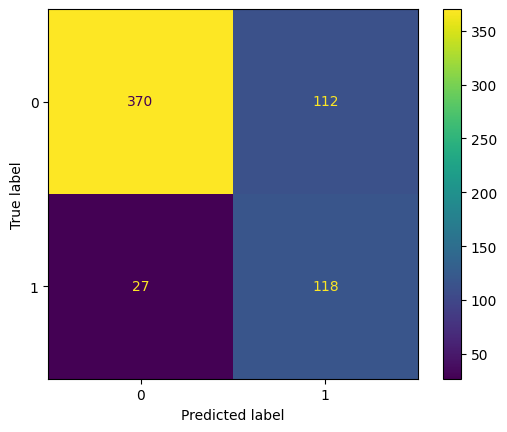

In [18]:
from sklearn import metrics
predicted = model.predict(X_val)
cm = metrics.confusion_matrix(Y_val, predicted)
display = metrics.ConfusionMatrixDisplay(cm).plot()

In [29]:
#Find predicted satisfaction for review and average satisfaction for restraunt
df['Predicted Customer Satisfaction'] = model.predict(val_vectorizer.fit_transform(df['Review']))
df['Average Satisfaction'] = df['Average Rating'].apply(lambda x: 'Low' if x < 4 else 'High')

,Unnamed: 0,Name,Street,Category,Price Tags,Average Rating,Review,Date,Rating,year,Customer Satisfaction,Predicted Customer Satisfaction,Average Satisfaction
0,0,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,sushi definitely quality however wait times lo...,2/18/2023,4,2023,High,High,Low
1,1,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,place delicious service great menu pure lot fr...,8/31/2022,5,2022,High,High,Low
2,2,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,place legit fantastic japanese food sure servi...,7/20/2022,5,2022,High,High,Low
3,3,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,totemo oishii desu sushimaeda finally japanese...,6/6/2022,5,2022,High,High,Low
4,4,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,slow get table even though place wasn busy brg...,9/27/2022,1,2022,Low,Low,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2688,2688,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,voted best place play pool agree i times week...,8/23/2016,5,2016,High,High,Low
2689,2689,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,update everytime go leave pissed off not worth...,9/10/2016,1,2016,Low,Low,Low
2690,2690,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,amazing pizza menu option dairyfree please sup...,2/23/2015,1,2015,Low,High,Low
2691,2691,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,cool spot grab beer service quick especially d...,10/23/2017,5,2017,High,Low,Low


In [32]:
#Get overall predicted value for the resturant
name = df.groupby(['Name', 'Predicted Customer Satisfaction'])['Predicted Customer Satisfaction'].count().unstack(fill_value=0)
result = name.apply(lambda row: 'High' if row['High'] > row['Low'] else 'Low', axis=1)
df['Average Predicted'] = df['Name'].map(result)


,Unnamed: 0,Name,Street,Category,Price Tags,Average Rating,Review,Date,Rating,year,Customer Satisfaction,Predicted Customer Satisfaction,Average Satisfaction,Average Predicted
0,0,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,sushi definitely quality however wait times lo...,2/18/2023,4,2023,High,High,Low,High
1,1,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,place delicious service great menu pure lot fr...,8/31/2022,5,2022,High,High,Low,High
2,2,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,place legit fantastic japanese food sure servi...,7/20/2022,5,2022,High,High,Low,High
3,3,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,totemo oishii desu sushimaeda finally japanese...,6/6/2022,5,2022,High,High,Low,High
4,4,SUSHI MAEDA,"Cherry St, Bur","japanese,restaurants,sush",ul,3.5,slow get table even though place wasn busy brg...,9/27/2022,1,2022,Low,Low,Low,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2688,2688,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,voted best place play pool agree i times week...,8/23/2016,5,2016,High,High,Low,Low
2689,2689,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,update everytime go leave pissed off not worth...,9/10/2016,1,2016,Low,Low,Low,Low
2690,2690,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,amazing pizza menu option dairyfree please sup...,2/23/2015,1,2015,Low,High,Low,Low
2691,2691,THREE NEEDS TAPROOM & BREWERY,Pearl St,"breweries,food,nightlife,poolhall",2,3.0,cool spot grab beer service quick especially d...,10/23/2017,5,2017,High,Low,Low,Low


In [43]:
#Get the proportion that are right
total_name = df['Name'].nunique()
matching_name = df[df['Average Predicted'] == df['Average Satisfaction']]['Name'].nunique()
matching = matching_name / total_name
matching

0.8256880733944955